# linear regreesion（线性回归）
注意：python版本为3.7.3， 
安装TensorFlow的方法：pip install tensorflow

In [5]:
import pandas as pd# pandas 是基于NumPy 的一种工具，该工具是为了解决数据分析任务而创建的。
import seaborn as sns#Seaborn是基于matplotlib的Python可视化库。 它提供了一个高级界面来绘制有吸引力的统计图形。
sns.set(context="notebook", style="whitegrid", palette="dark")
import matplotlib.pyplot as plt#Matplotlib 是Python中类似 MATLAB 的绘图工具
import tensorflow as tf
import numpy as np#numpy 是用来存储和处理大型矩阵的科学计算包

## 1 简单练习
输出一个5*5的单位矩阵

In [6]:
A = np.eye(5)
A

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## 2 单变量的线性回归
整个2的部分需要根据城市人口数量，预测开小吃店的利润 数据在ex1data1.txt里，第一列是城市人口数量，第二列是该城市小吃店利润。

### 2.1 Plotting the Data
读入数据，然后展示数据

In [7]:
#import pandas as pd
#pd.read_csv(filepath_or_buffer,header,parse_dates,index_col)
#返回DataFrame
df = pd.read_csv('ex1data1.txt', names=['population', 'profit'])#读取数据并赋予列名

df.head()#看前五行

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [8]:
df.info()#df.info()给出DataFrame数据的基本信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
population    97 non-null float64
profit        97 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


### 2.2看下原始数据

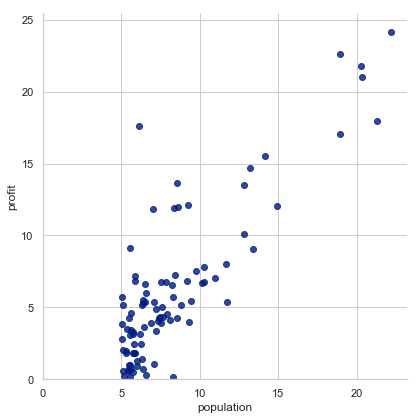

In [9]:
#import seaborn as sns
#lmplot()函数实际上我们用它来拟合和绘制回归线。
#lmplot()绘制散点图，需要用fit_reg = False 移去回归线
sns.lmplot('population', 'profit', df, height=6, fit_reg=False)
#Matplotlib的ylim()和xlim()函数使用设置数轴范围
plt.ylim(0,None)
plt.xlim(0,None)
plt.show()

In [10]:
def get_X(df):#读取特征
#     使用concat函数将x_0列加入X矩阵，亦即自变量矩阵
    ones = pd.DataFrame({'ones': np.ones(len(df))})#ones是m行1列的DataFrame,ones()返回一个全1的n维数组
    data = pd.concat([ones, df], axis=1)  # 合并数据，列拓展，axis=1
    #pandas提供了专门的用于索引DataFrame的方法，如果使用下标，最好使用iloc方法
    #values,以ndarray形式返回指定column的所有取值
    #[a,b]a指取哪行，b指取哪列
    return data.iloc[:, :-1].values# 这个操作返回 ndarray,不是矩阵


def get_y(df):#读取标签
#     最后一列是目标值，也就是因变量
    return np.array(df.iloc[:, -1])#df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     使得数据保持在一个维度
    #apply函数的第一个参数，这个参数是函数，相当于C/C++的函数指针。
    #column.mean()对每一列的数据求平均值,column.std()对每一列的数据求标准差
    f = lambda column: (column - column.mean()) / column.std()
    #import pandas as pd
    return df.apply(f)#特征缩放


In [11]:
def linear_regression(X_data, y_data, alpha, epoch, optimizer=tf.train.GradientDescentOptimizer):# 这个函数是旧金山的一个大神Lucas Shen写的
      # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)

    # construct the graph
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable("weights",
                            (X_data.shape[1], 1),
                            initializer=tf.constant_initializer())  # n*1

        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1

        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  # (m*1).T @ m*1 = 1*1

    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)

    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []

        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0, 0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:  # early break when it's converged
                # print('Converged at epoch {}'.format(i))
                break

    # clear the graph
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}  # just want to return in row vector format

In [12]:
data = pd.read_csv('ex1data1.txt', names=['population', 'profit'])#读取数据，并赋予列名

data.head()#看下数据前5行

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


### 2.3计算代价函数


In [13]:
X = get_X(data)
print(X.shape, type(X))#它的功能是查看矩阵或者数组的维数

y = get_y(data)
print(y.shape, type(y))
#看下数据维度

(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


In [14]:
theta = np.zeros(X.shape[1])#X.shape[1]=2,代表特征数n
theta

array([0., 0.])

In [32]:
def lr_cost(theta, X, y):
#     """
#     X: R(m*n), m 样本数, n 特征数
#     y: R(m)
#     theta : R(n), 线性回归的参数
#     """
    m = X.shape[0]#m为样本数

    inner = X @ theta - y  # R(m*1)，X @ theta等价于X.dot(theta)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    return inner.T @ inner / (2 * m)


In [33]:
lr_cost(theta, X, y)#返回theta的值


32.07273387745567

### 2.4batch gradient decent（批量梯度下降）

In [36]:
def gradient(theta, X, y):
#   偏导数
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)，X @ theta等价于X.dot(theta)

    return inner / m

In [54]:
def batch_gradient_decent(theta, X, y, epoch, alpha=0.01):
#   拟合线性回归，返回参数和代价
#     epoch: 批处理的轮数
#     alpha: 学习率
#     """
    cost_data = [lr_cost(theta, X, y)]#cost_data是个数组，存放J(θ)
    _theta = theta.copy()  # 拷贝一份，不和原来的theta混淆
    
    #循环更新θ
    for _ in range(epoch):
        _theta = _theta - alpha * gradient(_theta, X, y)
        cost_data.append(lr_cost(_theta, X, y))#将新的J(θ)加入cost_data
        #print(_theta)
    return _theta, cost_data
#批量梯度下降函数

In [55]:
epoch = 500
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch)
final_theta
#最终的theta

array([-2.29446559,  1.03216415])

In [74]:
cost_data

# 看下代价数据

[5.895228586444221,
 5.89009494311733,
 5.885004158443646,
 5.879932480491418,
 5.874879094762573,
 5.869843911806388,
 5.8648268653129305,
 5.8598278899321805,
 5.85484692057229,
 5.849883892376587,
 5.844938740722034,
 5.8400114012183595,
 5.8351018097072265,
 5.830209902261388,
 5.825335615183862,
 5.820478885007098,
 5.815639648492154,
 5.810817842627869,
 5.806013404630045,
 5.801226271940628,
 5.796456382226899,
 5.791703673380653,
 5.7869680835173956,
 5.782249550975539,
 5.777548014315598,
 5.772863412319381,
 5.768195683989214,
 5.76354476854712,
 5.758910605434049,
 5.754293134309077,
 5.749692295048627,
 5.745108027745684,
 5.740540272709012,
 5.735988970462381,
 5.731454061743792,
 5.726935487504702,
 5.722433188909257,
 5.717947107333528,
 5.713477184364749,
 5.709023361800549,
 5.704585581648199,
 5.700163786123856,
 5.6957579176518145,
 5.691367918863751,
 5.68699373259798,
 5.682635301898707,
 5.678292570015292,
 5.673965480401506,
 5.669653976714797,
 5.665358002815553

In [59]:
# 计算最终的代价
lr_cost(final_theta, X, y)

4.710415613829715

### 2.5visualize cost data（代价数据可视化）

D:\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


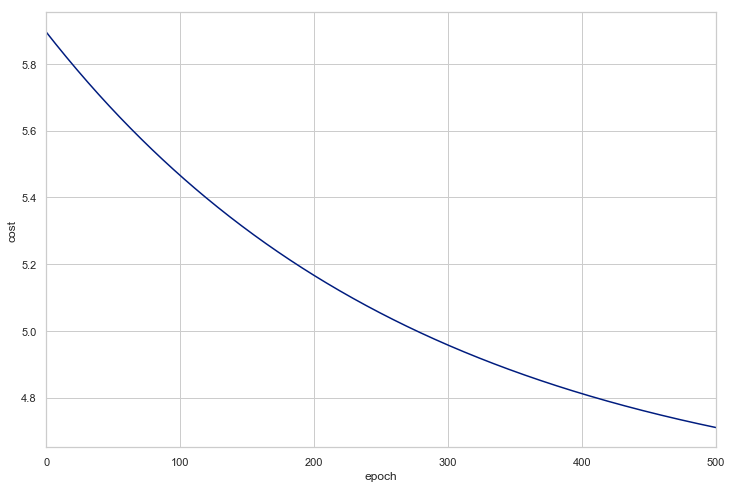

In [64]:
plt.figure(figsize=(12,8))
ax = sns.tsplot(cost_data, time=np.arange(epoch+1))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')
plt.show()
#可以看到从第二轮代价数据变换很大，接下来平稳了

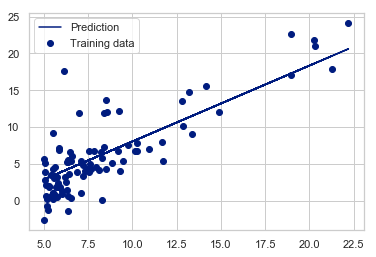

In [55]:
b = final_theta[0] # intercept，Y轴上的截距
m = final_theta[1] # slope，斜率
#画散点图
plt.scatter(data.population, data.profit, label="Training data")
#画回归线
plt.plot(data.population, data.population*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

## 3. multi-var batch gradient decent（多变量批量梯度下降）

In [56]:
X = get_X(data)
print(X.shape, type(X))

y = get_y(data)
print(y.shape, type(y))#看下数据的维度和类型

(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


In [57]:
alpha = 0.01#学习率
theta = np.zeros(X.shape[1])#X.shape[1]：特征数n
epoch = 500#轮数

In [58]:
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)

D:\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


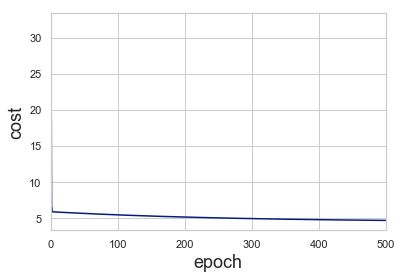

In [59]:
sns.tsplot(time=np.arange(len(cost_data)), data = cost_data)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('cost', fontsize=18)
plt.show()

In [60]:
final_theta

array([-2.28286727,  1.03099898])

## 4.learning rate（学习率）

In [61]:
base = np.logspace(-1, -5, num=4)
candidate = np.sort(np.concatenate((base, base*3)))
print(candidate)

[1.00000000e-05 3.00000000e-05 2.15443469e-04 6.46330407e-04
 4.64158883e-03 1.39247665e-02 1.00000000e-01 3.00000000e-01]


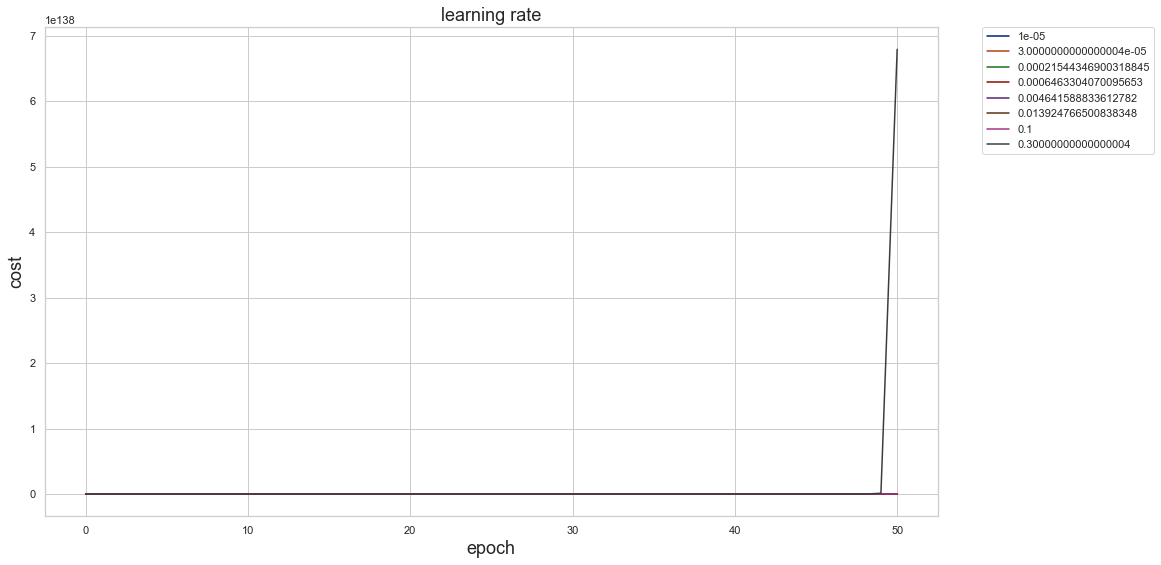

In [62]:
epoch=50

fig, ax = plt.subplots(figsize=(16, 9))

for alpha in candidate:
    _, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)
    ax.plot(np.arange(epoch+1), cost_data, label=alpha)

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('learning rate', fontsize=18)
plt.show()

## 5.normal equation（正规方程）

In [63]:
# 正规方程
def normalEqn(X, y):
    theta = np.linalg.inv(X.T@X)@X.T@y#X.T@X等价于X.T.dot(X)
    return theta

In [64]:
final_theta2=normalEqn(X, y)#感觉和批量梯度下降的theta的值有点差距
final_theta2

array([-3.89578088,  1.19303364])

### 5.1run the tensorflow graph over several optimizer

In [65]:
X_data = get_X(data)
print(X_data.shape, type(X_data))

y_data = get_y(data).reshape(len(X_data), 1)  # special treatment for tensorflow input data
print(y_data.shape, type(y_data))

(97, 2) <class 'numpy.ndarray'>
(97, 1) <class 'numpy.ndarray'>


In [66]:
epoch = 2000
alpha = 0.01

In [67]:
optimizer_dict={'GD': tf.train.GradientDescentOptimizer,
                'Adagrad': tf.train.AdagradOptimizer,
                'Adam': tf.train.AdamOptimizer,
                'Ftrl': tf.train.FtrlOptimizer,
                'RMS': tf.train.RMSPropOptimizer
               }
results = []
for name in optimizer_dict:
    res = linear_regression(X_data, y_data, alpha, epoch, optimizer=optimizer_dict[name])
    res['name'] = name
    results.append(res)

### 5.2画图

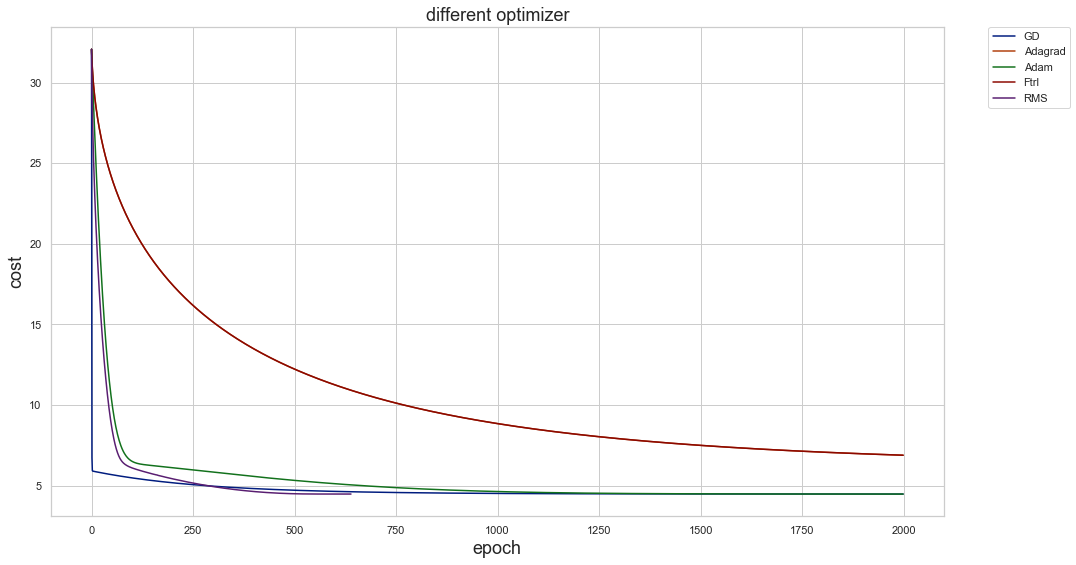

In [68]:
fig, ax = plt.subplots(figsize=(16, 9))

for res in results: 
    loss_data = res['loss']
    
#     print('for optimizer {}'.format(res['name']))
#     print('final parameters\n', res['parameters'])
#     print('final loss={}\n'.format(loss_data[-1]))
    ax.plot(np.arange(len(loss_data)), loss_data, label=res['name'])

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('different optimizer', fontsize=18)
plt.show()

array([[[[2.83182683, 3.52791411, 2.61812887, ..., 4.75678207,
          2.45169429, 3.16163091],
         [4.01449805, 1.81663596, 3.85340725, ..., 2.87462956,
          3.83892356, 3.37993639],
         [3.89245119, 4.51094762, 3.56445852, ..., 3.29637855,
          4.36213218, 3.74083207],
         ...,
         [3.34928036, 4.95049393, 2.58313912, ..., 4.42135943,
          3.16167035, 4.29499273],
         [2.52497041, 3.51176934, 3.75145456, ..., 3.30600473,
          3.48206146, 4.74130455],
         [3.31003974, 3.79680922, 3.17779663, ..., 2.22895379,
          3.92195958, 4.10006308]],

        [[2.01782885, 2.74102779, 2.14234538, ..., 3.16005203,
          2.51378048, 2.78997018],
         [2.85398729, 1.23385016, 3.44574202, ..., 2.2755139 ,
          2.13719375, 2.5885728 ],
         [2.89729024, 3.01495779, 2.38439178, ..., 2.50366073,
          3.38493441, 3.54700999],
         ...,
         [2.19167758, 3.31894912, 2.02661967, ..., 3.4040863 ,
          2.91173977, 3.7